In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import time 
from lightgbm import LGBMClassifier, LGBMRegressor
import lightgbm as lgb 
from sklearn.metrics import mean_squared_error, accuracy_score
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score
from collections import defaultdict 
from sklearn.decomposition import NMF
from sklearn.metrics import confusion_matrix
%matplotlib inline

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [3]:
df_train = pd.read_csv("fashion-mnist_train.csv")
df_test = pd.read_csv("fashion-mnist_test.csv")
df_train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,pixel40,pixel41,pixel42,pixel43,pixel44,pixel45,pixel46,pixel47,pixel48,pixel49,pixel50,pixel51,pixel52,pixel53,pixel54,pixel55,pixel56,pixel57,pixel58,pixel59,pixel60,pixel61,pixel62,pixel63,pixel64,pixel65,pixel66,pixel67,pixel68,pixel69,pixel70,pixel71,pixel72,pixel73,pixel74,pixel75,pixel76,pixel77,pixel78,pixel79,pixel80,pixel81,pixel82,pixel83,pixel84,pixel85,pixel86,pixel87,pixel88,pixel89,pixel90,pixel91,pixel92,pixel93,pixel94,pixel95,pixel96,pixel97,pixel98,pixel99,pixel100,pixel101,pixel102,pixel103,pixel104,pixel105,pixel106,pixel107,pixel108,pixel109,pixel110,pixel111,pixel112,pixel113,pixel114,pixel115,pixel116,pixel117,pixel118,pixel119,pixel120,pixel121,pixel122,pixel123,pixel124,pixel125,pixel126,pixel127,pixel128,pixel129,pixel130,pixel131,pixel132,pixel133,pixel134,pixel135,pixel136,pixel137,pixel138,pixel139,pixel140,pixel141,pixel142,pixel143,pixel144,pixel145,pixel146,pixel147,pixel148,pixel149,pixel150,pixel151,pixel152,pixel153,pixel154,pixel155,pixel156,pixel157,pixel158,pixel159,pixel160,pixel161,pixel162,pixel163,pixel164,pixel165,pixel166,pixel167,pixel168,pixel169,pixel170,pixel171,pixel172,pixel173,pixel174,pixel175,pixel176,pixel177,pixel178,pixel179,pixel180,pixel181,pixel182,pixel183,pixel184,pixel185,pixel186,pixel187,pixel188,pixel189,pixel190,pixel191,pixel192,pixel193,pixel194,pixel195,pixel196,pixel197,pixel198,pixel199,pixel200,pixel201,pixel202,pixel203,pixel204,pixel205,pixel206,pixel207,pixel208,pixel209,pixel210,pixel211,pixel212,pixel213,pixel214,pixel215,pixel216,pixel217,pixel218,pixel219,pixel220,pixel221,pixel222,pixel223,pixel224,pixel225,pixel226,pixel227,pixel228,pixel229,pixel230,pixel231,pixel232,pixel233,pixel234,pixel235,pixel236,pixel237,pixel238,pixel239,pixel240,pixel241,pixel242,pixel243,pixel244,pixel245,pixel246,pixel247,pixel248,pixel249,pixel250,pixel251,pixel252,pixel253,pixel254,pixel255,pixel256,pixel257,pixel258,pixel259,pixel260,pixel261,pixel262,pixel263,pixel264,pixel265,pixel266,pixel267,pixel268,pixel269,pixel270,pixel271,pixel272,pixel273,pixel274,pixel275,pixel276,pixel277,pixel278,pixel279,pixel280,pixel281,pixel282,pixel283,pixel284,pixel285,pixel286,pixel287,pixel288,pixel289,pixel290,pixel291,pixel292,pixel293,pixel294,pixel295,pixel296,pixel297,pixel298,pixel299,pixel300,pixel301,pixel302,pixel303,pixel304,pixel305,pixel306,pixel307,pixel308,pixel309,pixel310,pixel311,pixel312,pixel313,pixel314,pixel315,pixel316,pixel317,pixel318,pixel319,pixel320,pixel321,pixel322,pixel323,pixel324,pixel325,pixel326,pixel327,pixel328,pixel329,pixel330,pixel331,pixel332,pixel333,pixel334,pixel335,pixel336,pixel337,pixel338,pixel339,pixel340,pixel341,pixel342,pixel343,pixel344,pixel345,pixel346,pixel347,pixel348,pixel349,pixel350,pixel351,pixel352,pixel353,pixel354,pixel355,pixel356,pixel357,pixel358,pixel359,pixel360,pixel361,pixel362,pixel363,pixel364,pixel365,pixel366,pixel367,pixel368,pixel369,pixel370,pixel371,pixel372,pixel373,pixel374,pixel375,pixel376,pixel377,pixel378,pixel379,pixel380,pixel381,pixel382,pixel383,pixel384,pixel385,pixel386,pixel387,pixel388,pixel389,pixel390,pixel391,pixel392,pixel393,pixel394,pixel395,pixel396,pixel397,pixel398,pixel399,pixel400,pixel401,pixel402,pixel403,pixel404,pixel405,pixel406,pixel407,pixel408,pixel409,pixel410,pixel411,pixel412,pixel413,pixel414,pixel415,pixel416,pixel417,pixel418,pixel419,pixel420,pixel421,pixel422,pixel423,pixel424,pixel425,pixel426,pixel427,pixel428,pixel429,pixel430,pixel431,pixel432,pixel433,pixel434,pixel435,pixel436,pixel437,pixel438,pixel439,pixel440,pixel441,pixel442,pixel443,pixel444,pixel445,pixel446,pixel447,pixel448,pixel449,pixel450,pixel451,pixel452,pixel453,pixel454,pixel455,pixel4

In [4]:
df_train_pixels = df_train.iloc[:,1:] #slice target column out i.e. 1st column and keep only the pixels
df_target = df_train.iloc[:,0]
df_train_pixels.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,pixel40,pixel41,pixel42,pixel43,pixel44,pixel45,pixel46,pixel47,pixel48,pixel49,pixel50,pixel51,pixel52,pixel53,pixel54,pixel55,pixel56,pixel57,pixel58,pixel59,pixel60,pixel61,pixel62,pixel63,pixel64,pixel65,pixel66,pixel67,pixel68,pixel69,pixel70,pixel71,pixel72,pixel73,pixel74,pixel75,pixel76,pixel77,pixel78,pixel79,pixel80,pixel81,pixel82,pixel83,pixel84,pixel85,pixel86,pixel87,pixel88,pixel89,pixel90,pixel91,pixel92,pixel93,pixel94,pixel95,pixel96,pixel97,pixel98,pixel99,pixel100,pixel101,pixel102,pixel103,pixel104,pixel105,pixel106,pixel107,pixel108,pixel109,pixel110,pixel111,pixel112,pixel113,pixel114,pixel115,pixel116,pixel117,pixel118,pixel119,pixel120,pixel121,pixel122,pixel123,pixel124,pixel125,pixel126,pixel127,pixel128,pixel129,pixel130,pixel131,pixel132,pixel133,pixel134,pixel135,pixel136,pixel137,pixel138,pixel139,pixel140,pixel141,pixel142,pixel143,pixel144,pixel145,pixel146,pixel147,pixel148,pixel149,pixel150,pixel151,pixel152,pixel153,pixel154,pixel155,pixel156,pixel157,pixel158,pixel159,pixel160,pixel161,pixel162,pixel163,pixel164,pixel165,pixel166,pixel167,pixel168,pixel169,pixel170,pixel171,pixel172,pixel173,pixel174,pixel175,pixel176,pixel177,pixel178,pixel179,pixel180,pixel181,pixel182,pixel183,pixel184,pixel185,pixel186,pixel187,pixel188,pixel189,pixel190,pixel191,pixel192,pixel193,pixel194,pixel195,pixel196,pixel197,pixel198,pixel199,pixel200,pixel201,pixel202,pixel203,pixel204,pixel205,pixel206,pixel207,pixel208,pixel209,pixel210,pixel211,pixel212,pixel213,pixel214,pixel215,pixel216,pixel217,pixel218,pixel219,pixel220,pixel221,pixel222,pixel223,pixel224,pixel225,pixel226,pixel227,pixel228,pixel229,pixel230,pixel231,pixel232,pixel233,pixel234,pixel235,pixel236,pixel237,pixel238,pixel239,pixel240,pixel241,pixel242,pixel243,pixel244,pixel245,pixel246,pixel247,pixel248,pixel249,pixel250,pixel251,pixel252,pixel253,pixel254,pixel255,pixel256,pixel257,pixel258,pixel259,pixel260,pixel261,pixel262,pixel263,pixel264,pixel265,pixel266,pixel267,pixel268,pixel269,pixel270,pixel271,pixel272,pixel273,pixel274,pixel275,pixel276,pixel277,pixel278,pixel279,pixel280,pixel281,pixel282,pixel283,pixel284,pixel285,pixel286,pixel287,pixel288,pixel289,pixel290,pixel291,pixel292,pixel293,pixel294,pixel295,pixel296,pixel297,pixel298,pixel299,pixel300,pixel301,pixel302,pixel303,pixel304,pixel305,pixel306,pixel307,pixel308,pixel309,pixel310,pixel311,pixel312,pixel313,pixel314,pixel315,pixel316,pixel317,pixel318,pixel319,pixel320,pixel321,pixel322,pixel323,pixel324,pixel325,pixel326,pixel327,pixel328,pixel329,pixel330,pixel331,pixel332,pixel333,pixel334,pixel335,pixel336,pixel337,pixel338,pixel339,pixel340,pixel341,pixel342,pixel343,pixel344,pixel345,pixel346,pixel347,pixel348,pixel349,pixel350,pixel351,pixel352,pixel353,pixel354,pixel355,pixel356,pixel357,pixel358,pixel359,pixel360,pixel361,pixel362,pixel363,pixel364,pixel365,pixel366,pixel367,pixel368,pixel369,pixel370,pixel371,pixel372,pixel373,pixel374,pixel375,pixel376,pixel377,pixel378,pixel379,pixel380,pixel381,pixel382,pixel383,pixel384,pixel385,pixel386,pixel387,pixel388,pixel389,pixel390,pixel391,pixel392,pixel393,pixel394,pixel395,pixel396,pixel397,pixel398,pixel399,pixel400,pixel401,pixel402,pixel403,pixel404,pixel405,pixel406,pixel407,pixel408,pixel409,pixel410,pixel411,pixel412,pixel413,pixel414,pixel415,pixel416,pixel417,pixel418,pixel419,pixel420,pixel421,pixel422,pixel423,pixel424,pixel425,pixel426,pixel427,pixel428,pixel429,pixel430,pixel431,pixel432,pixel433,pixel434,pixel435,pixel436,pixel437,pixel438,pixel439,pixel440,pixel441,pixel442,pixel443,pixel444,pixel445,pixel446,pixel447,pixel448,pixel449,pixel450,pixel451,pixel452,pixel453,pixel454,pixel455,pixel456,pix

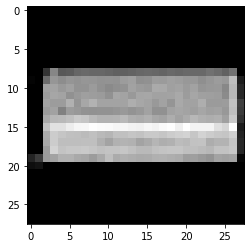

In [6]:
#pixels of 1st image
image_1 = df_train_pixels.values[1000].reshape(28,28)
plt.imshow(image_1, cmap='gray')

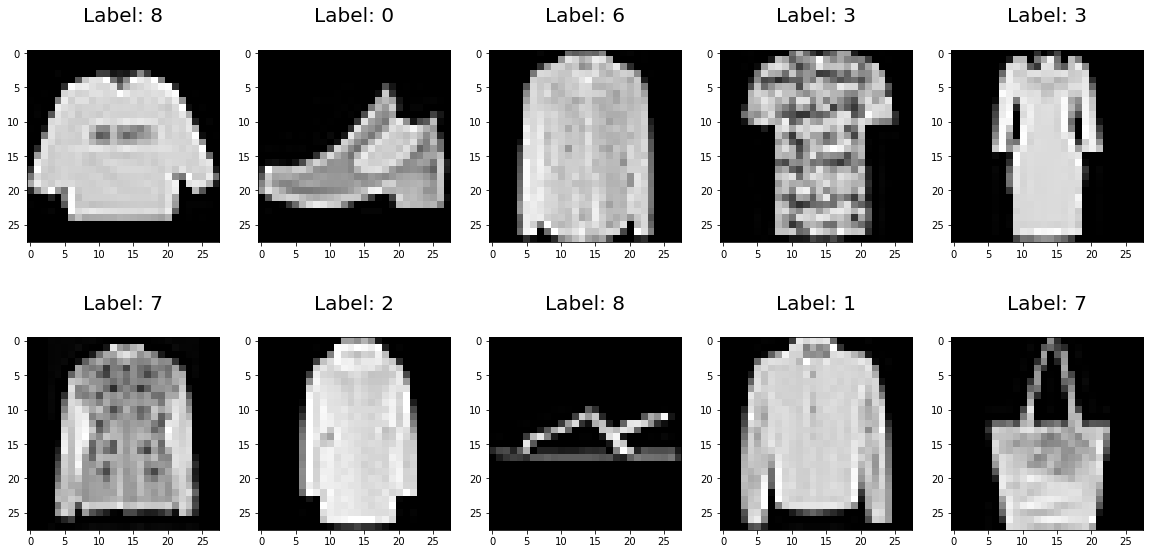

In [8]:
plt.figure(figsize=(20,15))
for index, (image, label) in enumerate(zip(df_train_pixels[1000:1010], 
                                           df_target[1000:1010])):
    plt.subplot(3, 5, index + 1)
    plt.imshow(np.reshape(df_train_pixels.values[index], (28,28)), cmap=plt.cm.gray)
    plt.title('Label: %i\n' % label, fontsize = 20);

In [91]:
#import sklearn manifold library
from sklearn import manifold
tsne = manifold.TSNE(n_components=2, random_state=1)
transf_data = tsne.fit_transform(df_train_pixels[:10000].to_numpy())
df_tsne = pd.DataFrame(np.column_stack((transf_data, df_target[:10000])),
                      columns = ["X", "y", "label"])
df_tsne.head()

,X,y,label
0,-18.682383,-19.238070,2.0
1,31.489950,-49.527779,9.0
2,-45.569893,11.848470,6.0
3,-30.807640,59.364529,0.0
4,-5.844800,43.694103,3.0


<AxesSubplot:xlabel='X', ylabel='y'>

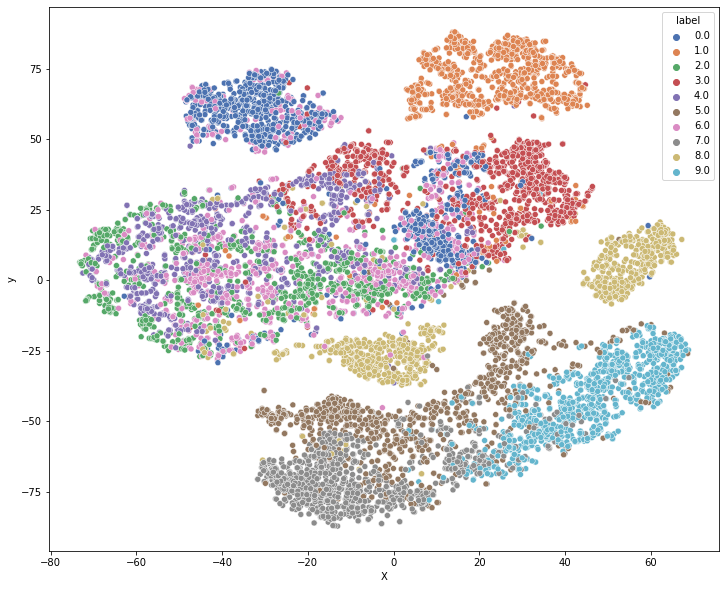

In [92]:
fig= plt.figure(figsize=(12,10))
sns.scatterplot(data=df_tsne, x="X", y="y", hue="label", palette="deep")

In [14]:
#import sklearn manifold library
from sklearn import manifold
tsne = manifold.TSNE(n_components=2, random_state=1)
transf_dataall = tsne.fit_transform(df_train_pixels.to_numpy())
df_tsneall = pd.DataFrame(np.column_stack((transf_dataall, df_target)),
                      columns = ["X", "y", "label"])
df_tsneall.head()

,X,y,label
0,-26.139849,-32.569775,2.0
1,-16.185869,12.960623,9.0
2,9.005284,-36.360489,6.0
3,-28.202713,-10.101283,0.0
4,-9.155207,-0.911801,3.0


<AxesSubplot:xlabel='X', ylabel='y'>

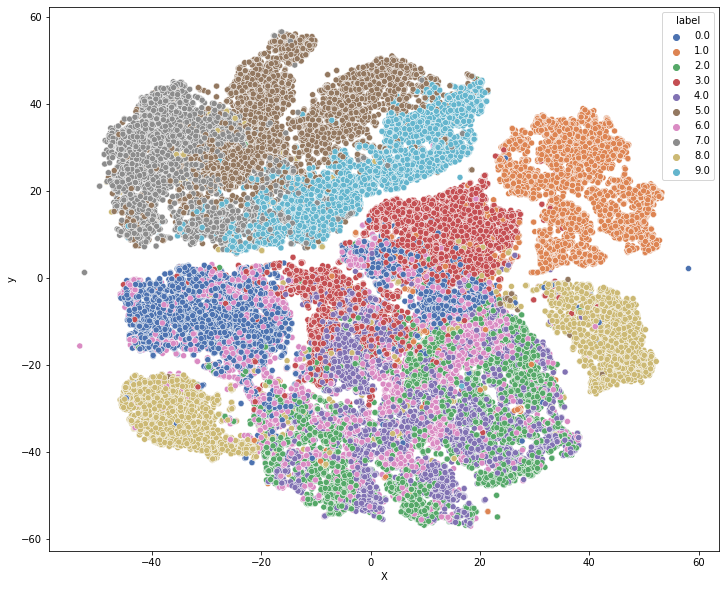

In [15]:
fig= plt.figure(figsize=(12,10))
sns.scatterplot(data=df_tsneall, x="X", y="y", hue="label", palette="deep")

K means 

In [16]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler();
#fitting training set; .fit is used to fit/train data frequently and quickly
#seperating label from rest of the features
bw_df_train_nl = df_train.drop(['label'],axis=1)
bw_df_test_nl = df_test.drop(['label'],axis=1)
scaler.fit(bw_df_train_nl)
#transform or map in both test and train set
df_train_nl_no_pca = scaler.transform(bw_df_train_nl)
df_test_nl_no_pca = scaler.transform(bw_df_test_nl)

In [20]:
#using kmeans clustering with 784 features
from sklearn.cluster import KMeans
start_time = time.time()
kmeans1 = KMeans(init = "k-means++", n_clusters=10, n_init=35)
kmeans1.fit(df_train_nl_no_pca)
print("using kmeans clustering with 784 features took %s seconds" % (time.time() - start_time))

using kmeans clustering with 784 features took 114.46167492866516 seconds


In [21]:
#attributes of KMeans() without PCA
kmeans1_cluster_labels = kmeans1.labels_
print(kmeans1_cluster_labels)
print(len(kmeans1_cluster_labels))
print("The labels of the clusters (without pca) are " + str(np.unique(kmeans1_cluster_labels)))

[4 3 2 ... 6 6 9]
60000
The labels of the clusters (without pca) are [0 1 2 3 4 5 6 7 8 9]


In [23]:
#defining actual number of labels of train dataset
label_column = df_train['label']
print(label_column.shape)
labels = len(np.unique(label_column))
print(labels)
label_names = {0:'T-shirt/top', 1:'Trouser',2: 'Pullover',3: 'Dress',4: 'Coat',5:
               'Sandal',6: 'Shirt', 7:'Sneaker',8:  'Bag',9: 'Ankle boot'}

(60000,)
10


In [24]:
num_cluster_labels_no_pca = len(np.unique(kmeans1_cluster_labels))
#assigning indexes into respective cluster members
cluster_indexes_no_pca = [[] for i in range(labels)]
#print(cluster_indexes)
for i,label in enumerate(kmeans1_cluster_labels):
    for n in range(num_cluster_labels_no_pca):
        if label == n:
            cluster_indexes_no_pca[n].append(i)
        else:
            continue
#number of datapoints in individual clusters
print('Without PCA')
for i in range(num_cluster_labels_no_pca):
    print('No. of items in Cluster ' + str(i) + ': ' + str(len(cluster_indexes_no_pca[i])))

Without PCA
No. of items in Cluster 0: 7410
No. of items in Cluster 1: 7616
No. of items in Cluster 2: 9278
No. of items in Cluster 3: 4709
No. of items in Cluster 4: 2307
No. of items in Cluster 5: 9112
No. of items in Cluster 6: 2506
No. of items in Cluster 7: 8027
No. of items in Cluster 8: 2338
No. of items in Cluster 9: 6697


In [27]:
#assigning actual label values(from train dataset) along side the indices of items of each cluster
Y_label_values_no_pca = [ [] for i in range(labels)]
for i in range(labels):
    Y_label_values_no_pca[i]= label_column[cluster_indexes_no_pca[i]] 

In [29]:
#number of dataitems of a certain category in each cluster
label_count_no_pca = [[] for i in range(labels)]
for index, label in enumerate(Y_label_values_no_pca):
    unique,count = np.unique(label, return_counts = True) #returns the individual label values and counts as lists
    label_count_no_pca[index]= dict(zip(unique,count)) #converts two lists into a dictionary
print(label_count_no_pca[0])   
print(label_count_no_pca[1])   

{0: 3451, 1: 216, 2: 137, 3: 1549, 4: 903, 5: 1, 6: 1109, 8: 35, 9: 9}
{0: 521, 1: 165, 2: 462, 3: 500, 4: 250, 5: 3938, 6: 708, 7: 534, 8: 384, 9: 154}


Cluster Visualization without PCA


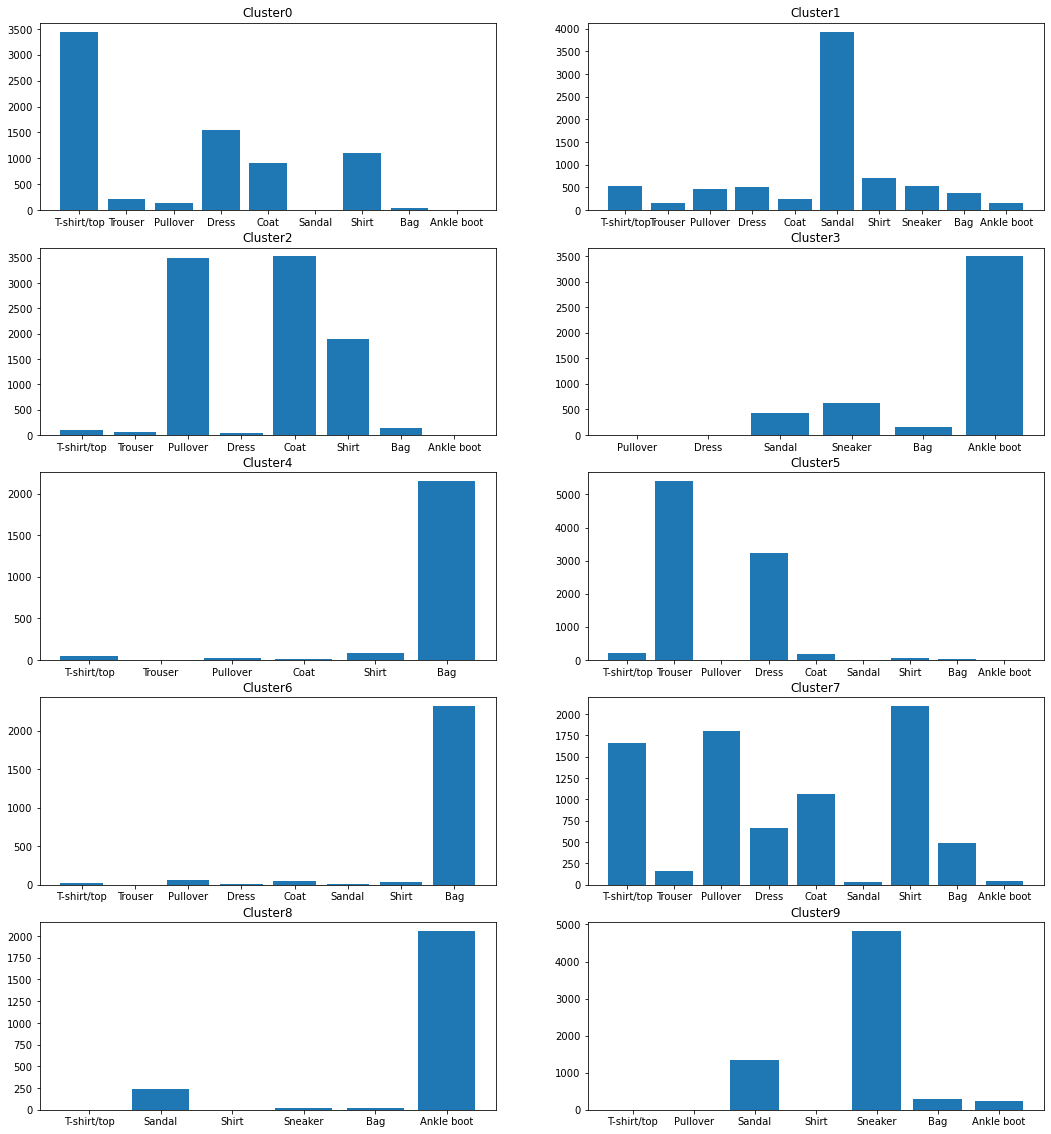

In [31]:
#Visualization of cluster points using barplots
print('Cluster Visualization without PCA')
plt.figure(figsize=(18,20))
for i in range(1,11):
    plt.subplot(5,2,i)
    label_count_=label_count_no_pca[i-1]
    plt.bar(range(len(label_count_)),list(label_count_.values()),align='center')
    plt.title('Cluster' + str(i-1))
    a=[]
    for key,value in label_count_.items():
        for key1, value1 in label_names.items():
            if key1 == key:
                a.append(value1)
                break
    plt.xticks(range(len(a)),a)  

In [36]:
df_train.head() 

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,pixel40,pixel41,pixel42,pixel43,pixel44,pixel45,pixel46,pixel47,pixel48,pixel49,pixel50,pixel51,pixel52,pixel53,pixel54,pixel55,pixel56,pixel57,pixel58,pixel59,pixel60,pixel61,pixel62,pixel63,pixel64,pixel65,pixel66,pixel67,pixel68,pixel69,pixel70,pixel71,pixel72,pixel73,pixel74,pixel75,pixel76,pixel77,pixel78,pixel79,pixel80,pixel81,pixel82,pixel83,pixel84,pixel85,pixel86,pixel87,pixel88,pixel89,pixel90,pixel91,pixel92,pixel93,pixel94,pixel95,pixel96,pixel97,pixel98,pixel99,pixel100,pixel101,pixel102,pixel103,pixel104,pixel105,pixel106,pixel107,pixel108,pixel109,pixel110,pixel111,pixel112,pixel113,pixel114,pixel115,pixel116,pixel117,pixel118,pixel119,pixel120,pixel121,pixel122,pixel123,pixel124,pixel125,pixel126,pixel127,pixel128,pixel129,pixel130,pixel131,pixel132,pixel133,pixel134,pixel135,pixel136,pixel137,pixel138,pixel139,pixel140,pixel141,pixel142,pixel143,pixel144,pixel145,pixel146,pixel147,pixel148,pixel149,pixel150,pixel151,pixel152,pixel153,pixel154,pixel155,pixel156,pixel157,pixel158,pixel159,pixel160,pixel161,pixel162,pixel163,pixel164,pixel165,pixel166,pixel167,pixel168,pixel169,pixel170,pixel171,pixel172,pixel173,pixel174,pixel175,pixel176,pixel177,pixel178,pixel179,pixel180,pixel181,pixel182,pixel183,pixel184,pixel185,pixel186,pixel187,pixel188,pixel189,pixel190,pixel191,pixel192,pixel193,pixel194,pixel195,pixel196,pixel197,pixel198,pixel199,pixel200,pixel201,pixel202,pixel203,pixel204,pixel205,pixel206,pixel207,pixel208,pixel209,pixel210,pixel211,pixel212,pixel213,pixel214,pixel215,pixel216,pixel217,pixel218,pixel219,pixel220,pixel221,pixel222,pixel223,pixel224,pixel225,pixel226,pixel227,pixel228,pixel229,pixel230,pixel231,pixel232,pixel233,pixel234,pixel235,pixel236,pixel237,pixel238,pixel239,pixel240,pixel241,pixel242,pixel243,pixel244,pixel245,pixel246,pixel247,pixel248,pixel249,pixel250,pixel251,pixel252,pixel253,pixel254,pixel255,pixel256,pixel257,pixel258,pixel259,pixel260,pixel261,pixel262,pixel263,pixel264,pixel265,pixel266,pixel267,pixel268,pixel269,pixel270,pixel271,pixel272,pixel273,pixel274,pixel275,pixel276,pixel277,pixel278,pixel279,pixel280,pixel281,pixel282,pixel283,pixel284,pixel285,pixel286,pixel287,pixel288,pixel289,pixel290,pixel291,pixel292,pixel293,pixel294,pixel295,pixel296,pixel297,pixel298,pixel299,pixel300,pixel301,pixel302,pixel303,pixel304,pixel305,pixel306,pixel307,pixel308,pixel309,pixel310,pixel311,pixel312,pixel313,pixel314,pixel315,pixel316,pixel317,pixel318,pixel319,pixel320,pixel321,pixel322,pixel323,pixel324,pixel325,pixel326,pixel327,pixel328,pixel329,pixel330,pixel331,pixel332,pixel333,pixel334,pixel335,pixel336,pixel337,pixel338,pixel339,pixel340,pixel341,pixel342,pixel343,pixel344,pixel345,pixel346,pixel347,pixel348,pixel349,pixel350,pixel351,pixel352,pixel353,pixel354,pixel355,pixel356,pixel357,pixel358,pixel359,pixel360,pixel361,pixel362,pixel363,pixel364,pixel365,pixel366,pixel367,pixel368,pixel369,pixel370,pixel371,pixel372,pixel373,pixel374,pixel375,pixel376,pixel377,pixel378,pixel379,pixel380,pixel381,pixel382,pixel383,pixel384,pixel385,pixel386,pixel387,pixel388,pixel389,pixel390,pixel391,pixel392,pixel393,pixel394,pixel395,pixel396,pixel397,pixel398,pixel399,pixel400,pixel401,pixel402,pixel403,pixel404,pixel405,pixel406,pixel407,pixel408,pixel409,pixel410,pixel411,pixel412,pixel413,pixel414,pixel415,pixel416,pixel417,pixel418,pixel419,pixel420,pixel421,pixel422,pixel423,pixel424,pixel425,pixel426,pixel427,pixel428,pixel429,pixel430,pixel431,pixel432,pixel433,pixel434,pixel435,pixel436,pixel437,pixel438,pixel439,pixel440,pixel441,pixel442,pixel443,pixel444,pixel445,pixel446,pixel447,pixel448,pixel449,pixel450,pixel451,pixel452,pixel453,pixel454,pixel455,pixel4

See cluster 6 

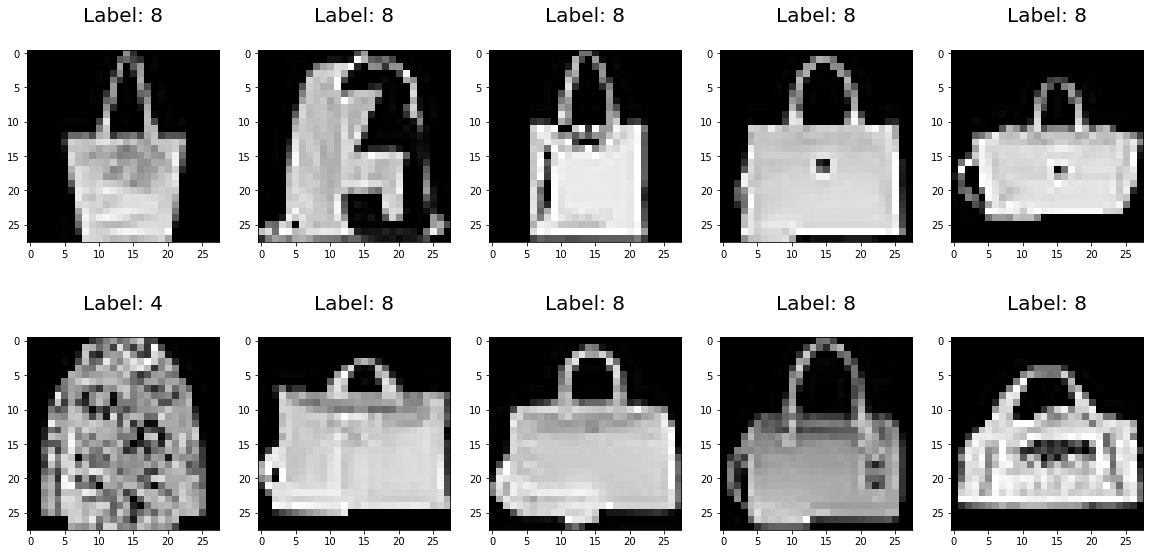

In [65]:
plt.figure(figsize=(20,15))
cluster_6_samples = cluster_indexes_no_pca[6][:10]
df_train_pixels_6 = df_train_pixels.iloc[cluster_6_samples]
df_target_6 = df_target.iloc[cluster_6_samples]
for index, (image, label) in enumerate(zip(df_train_pixels_6, 
                                           df_target_6)):
    plt.subplot(3, 5, index + 1)
    plt.imshow(np.reshape(df_train_pixels_6.values[index], (28,28)), cmap=plt.cm.gray)
    plt.title('Label: %i\n' % label, fontsize = 20);

See cluster 4

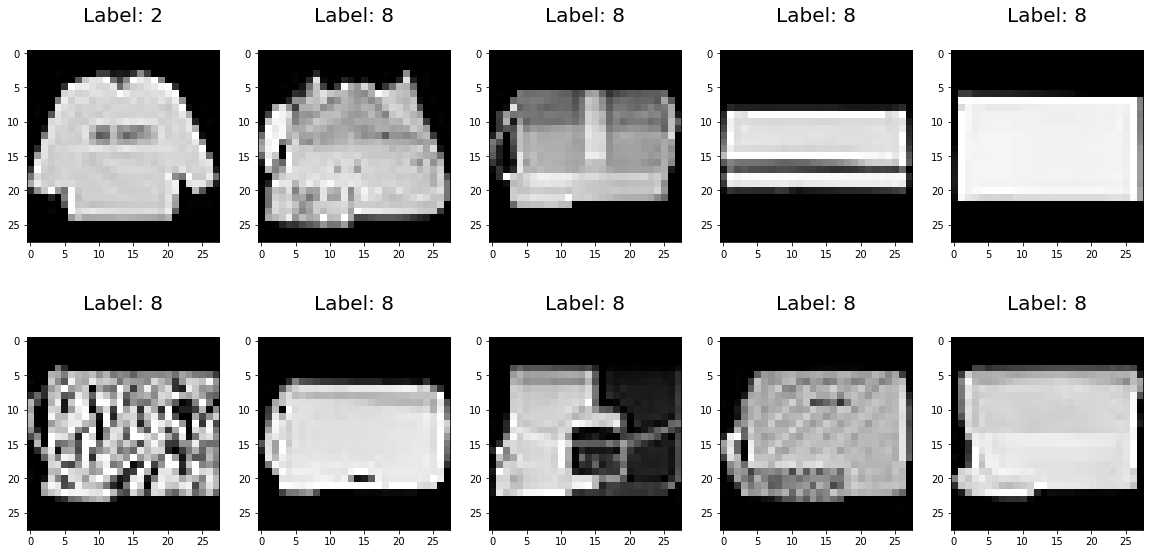

In [66]:
plt.figure(figsize=(20,15))
cluster_4_samples = cluster_indexes_no_pca[4][:10]
df_train_pixels_4 = df_train_pixels.iloc[cluster_4_samples]
df_target_4 = df_target.iloc[cluster_4_samples]
for index, (image, label) in enumerate(zip(df_train_pixels_4, 
                                           df_target_4)):
    plt.subplot(3, 5, index + 1)
    plt.imshow(np.reshape(df_train_pixels_4.values[index], (28,28)), cmap=plt.cm.gray)
    plt.title('Label: %i\n' % label, fontsize = 20);

See cluster 3

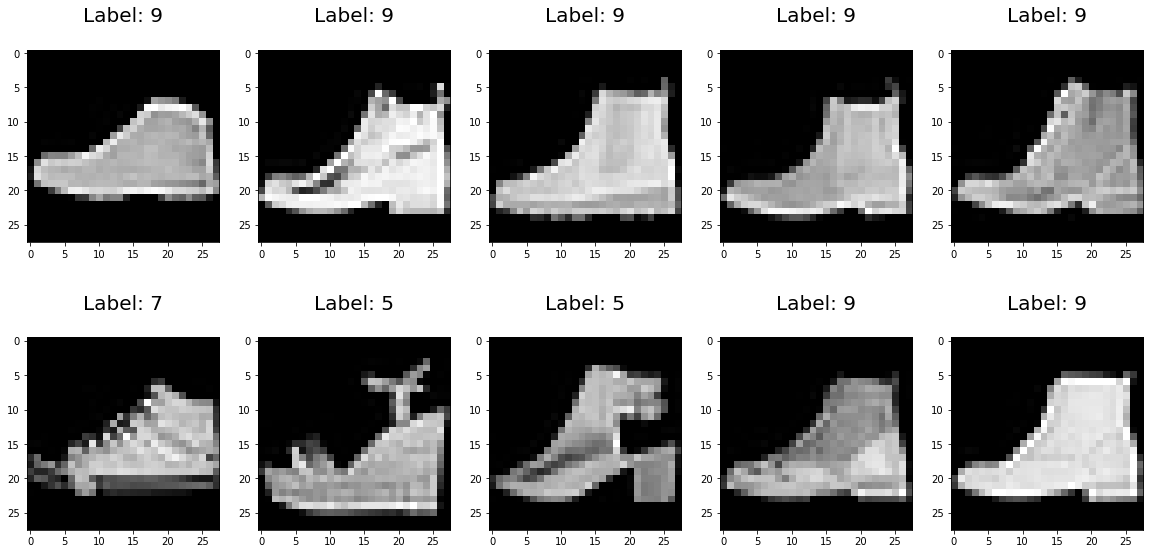

In [69]:
plt.figure(figsize=(20,15))
cluster_3_samples = cluster_indexes_no_pca[3][100:110]
df_train_pixels_3 = df_train_pixels.iloc[cluster_3_samples]
df_target_3 = df_target.iloc[cluster_3_samples]
for index, (image, label) in enumerate(zip(df_train_pixels_3, 
                                           df_target_3)):
    plt.subplot(3, 5, index + 1)
    plt.imshow(np.reshape(df_train_pixels_3.values[index], (28,28)), cmap=plt.cm.gray)
    plt.title('Label: %i\n' % label, fontsize = 20);

See cluster 8

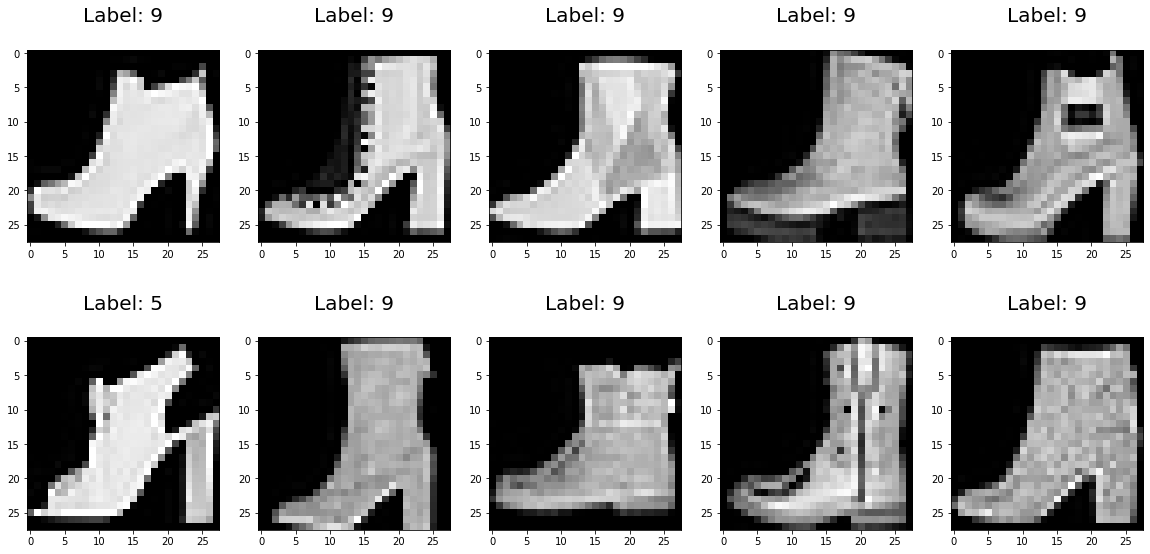

In [71]:
plt.figure(figsize=(20,15))
cluster_8_samples = cluster_indexes_no_pca[8][60:70]
df_train_pixels_8 = df_train_pixels.iloc[cluster_8_samples]
df_target_8 = df_target.iloc[cluster_8_samples]
for index, (image, label) in enumerate(zip(df_train_pixels_8, 
                                           df_target_8)):
    plt.subplot(3, 5, index + 1)
    plt.imshow(np.reshape(df_train_pixels_8.values[index], (28,28)), cmap=plt.cm.gray)
    plt.title('Label: %i\n' % label, fontsize = 20);

See cluster 2 

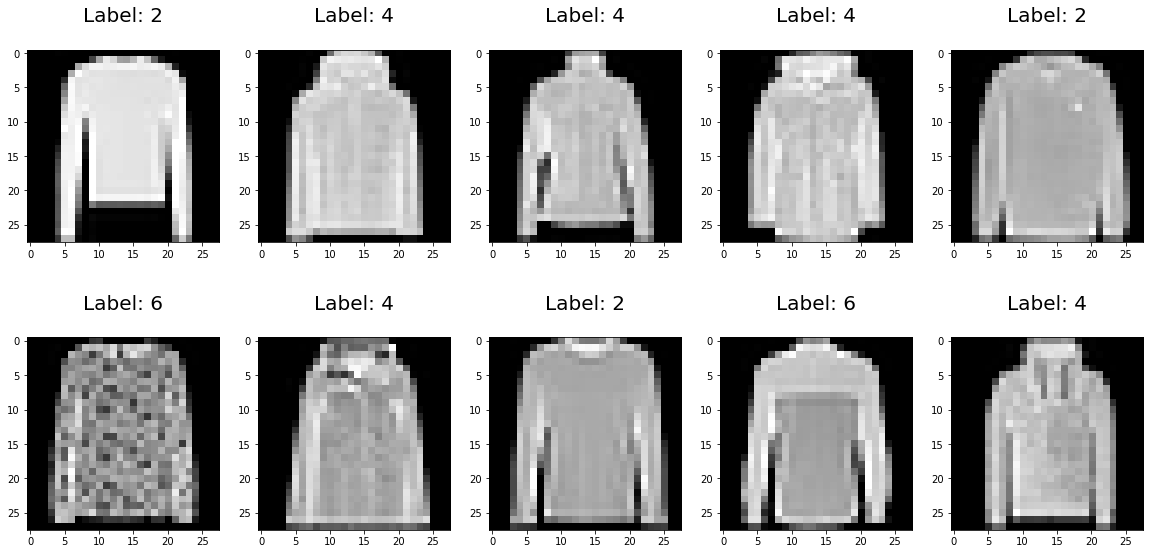

In [75]:
plt.figure(figsize=(20,15))
cluster_2_samples = cluster_indexes_no_pca[2][10:20]
df_train_pixels_2 = df_train_pixels.iloc[cluster_2_samples]
df_target_2 = df_target.iloc[cluster_2_samples]
for index, (image, label) in enumerate(zip(df_train_pixels_2, 
                                           df_target_2)):
    plt.subplot(3, 5, index + 1)
    plt.imshow(np.reshape(df_train_pixels_2.values[index], (28,28)), cmap=plt.cm.gray)
    plt.title('Label: %i\n' % label, fontsize = 20);

See cluster 9

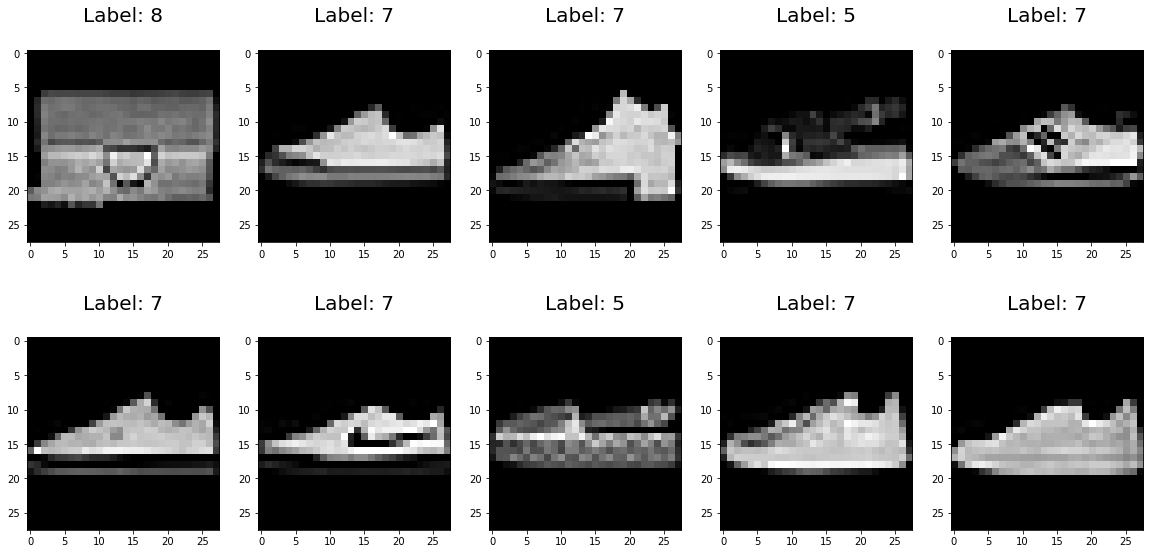

In [77]:
plt.figure(figsize=(20,15))
cluster_9_samples = cluster_indexes_no_pca[9][10:20]
df_train_pixels_9 = df_train_pixels.iloc[cluster_9_samples]
df_target_9 = df_target.iloc[cluster_9_samples]
for index, (image, label) in enumerate(zip(df_train_pixels_9, 
                                           df_target_9)):
    plt.subplot(3, 5, index + 1)
    plt.imshow(np.reshape(df_train_pixels_9.values[index], (28,28)), cmap=plt.cm.gray)
    plt.title('Label: %i\n' % label, fontsize = 20);

See cluster 7

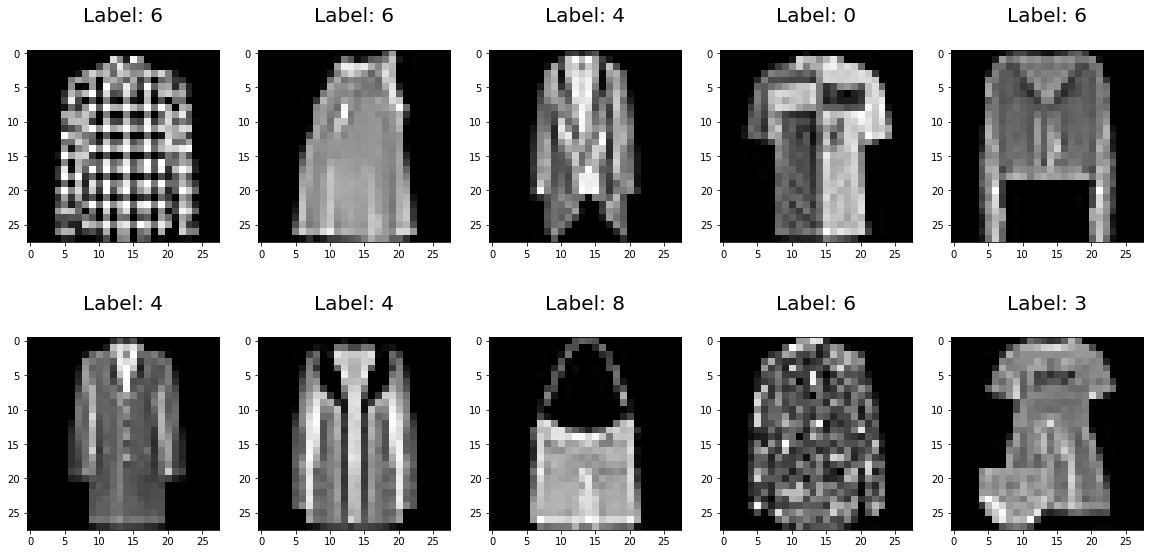

In [80]:
plt.figure(figsize=(20,15))
cluster_7_samples = cluster_indexes_no_pca[7][20:30]
df_train_pixels_7 = df_train_pixels.iloc[cluster_7_samples]
df_target_7 = df_target.iloc[cluster_7_samples]
for index, (image, label) in enumerate(zip(df_train_pixels_7, 
                                           df_target_7)):
    plt.subplot(3, 5, index + 1)
    plt.imshow(np.reshape(df_train_pixels_7.values[index], (28,28)), cmap=plt.cm.gray)
    plt.title('Label: %i\n' % label, fontsize = 20);

See cluster 5

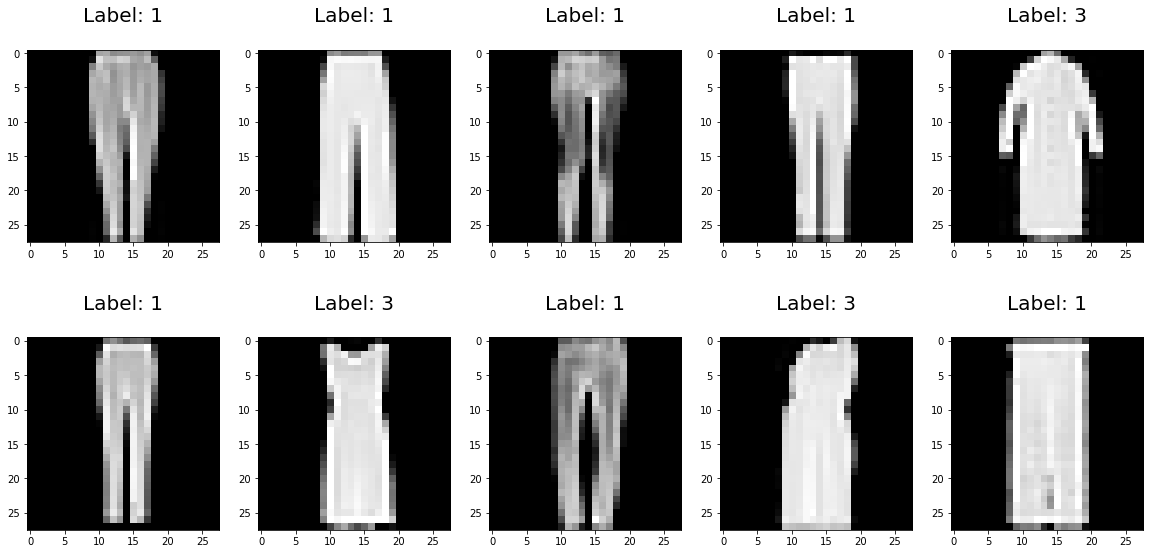

In [83]:
plt.figure(figsize=(20,15))
cluster_5_samples = cluster_indexes_no_pca[5][40:50]
df_train_pixels_5 = df_train_pixels.iloc[cluster_5_samples]
df_target_5 = df_target.iloc[cluster_5_samples]
for index, (image, label) in enumerate(zip(df_train_pixels_5, 
                                           df_target_5)):
    plt.subplot(3, 5, index + 1)
    plt.imshow(np.reshape(df_train_pixels_5.values[index], (28,28)), cmap=plt.cm.gray)
    plt.title('Label: %i\n' % label, fontsize = 20);

See cluster 0 

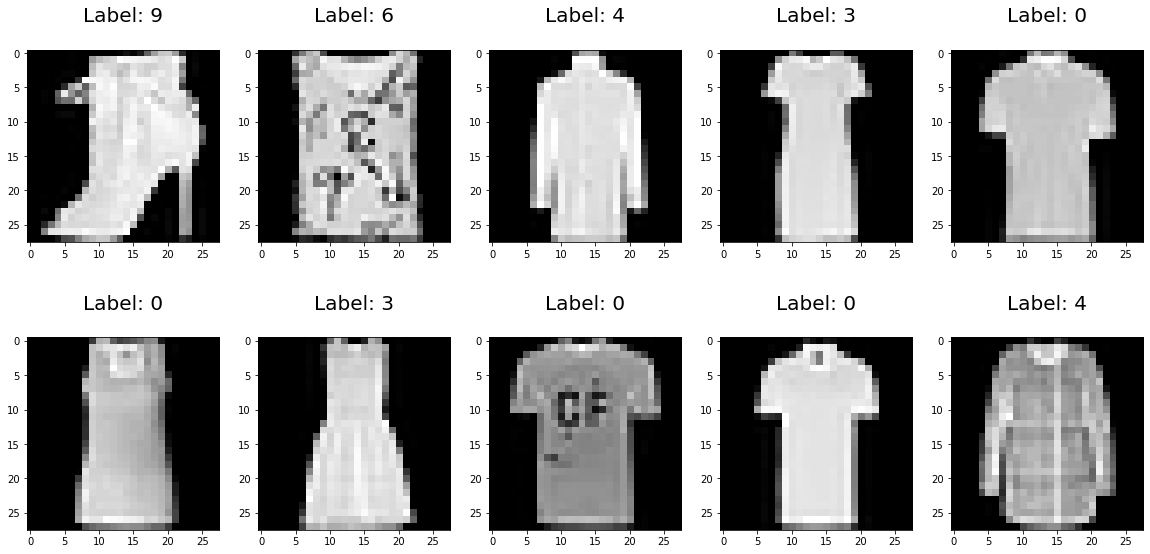

In [84]:
plt.figure(figsize=(20,15))
cluster_0_samples = cluster_indexes_no_pca[0][40:50]
df_train_pixels_0 = df_train_pixels.iloc[cluster_0_samples]
df_target_0 = df_target.iloc[cluster_0_samples]
for index, (image, label) in enumerate(zip(df_train_pixels_0, 
                                           df_target_0)):
    plt.subplot(3, 5, index + 1)
    plt.imshow(np.reshape(df_train_pixels_0.values[index], (28,28)), cmap=plt.cm.gray)
    plt.title('Label: %i\n' % label, fontsize = 20);

See cluster 1

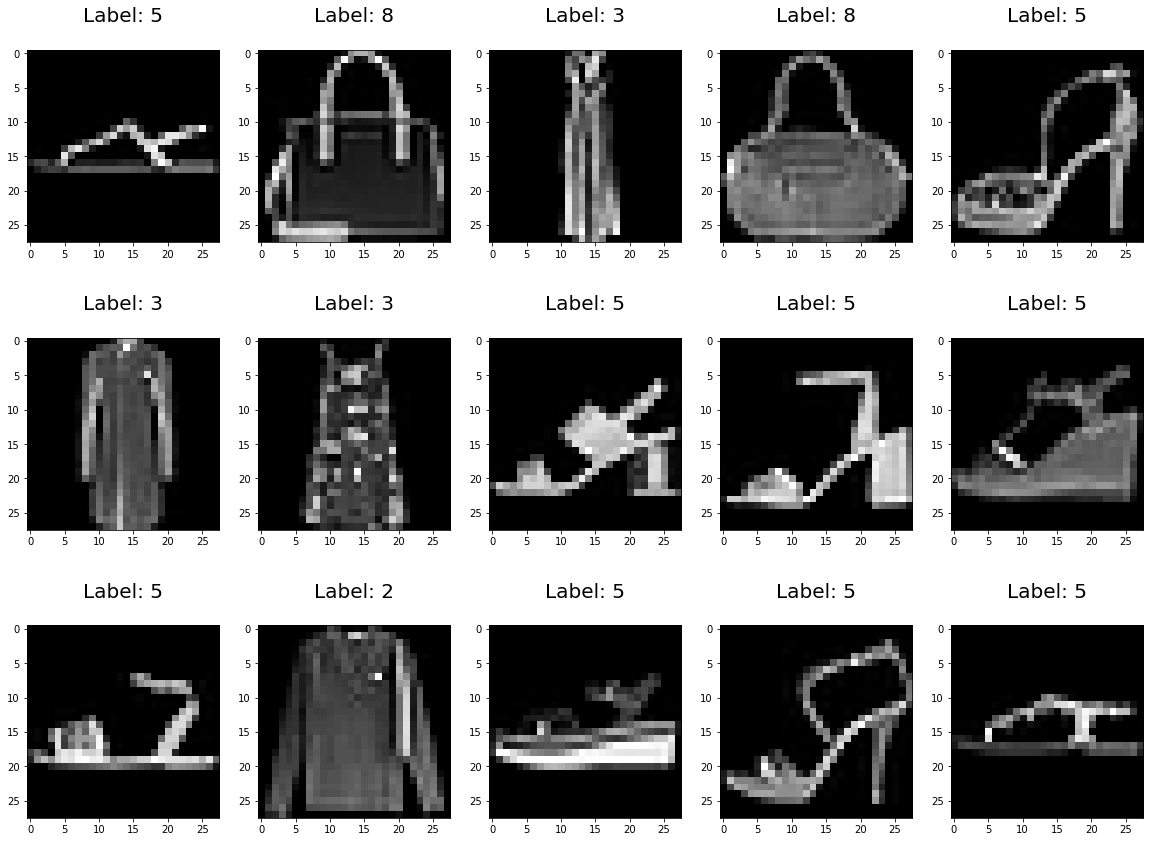

In [88]:
plt.figure(figsize=(20,15))
cluster_1_samples = cluster_indexes_no_pca[1][:15]
df_train_pixels_1 = df_train_pixels.iloc[cluster_1_samples]
df_target_1 = df_target.iloc[cluster_1_samples]
for index, (image, label) in enumerate(zip(df_train_pixels_1, 
                                           df_target_1)):
    plt.subplot(3, 5, index + 1)
    plt.imshow(np.reshape(df_train_pixels_1.values[index], (28,28)), cmap=plt.cm.gray)
    plt.title('Label: %i\n' % label, fontsize = 20);

LightGBM

In [5]:
# Perform train-test split
X_train, y_train, X_test, y_test = df_train.iloc[:,1:], df_train['label'], df_test.iloc[:,1:], df_test['label']
X_train.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,pixel40,pixel41,pixel42,pixel43,pixel44,pixel45,pixel46,pixel47,pixel48,pixel49,pixel50,pixel51,pixel52,pixel53,pixel54,pixel55,pixel56,pixel57,pixel58,pixel59,pixel60,pixel61,pixel62,pixel63,pixel64,pixel65,pixel66,pixel67,pixel68,pixel69,pixel70,pixel71,pixel72,pixel73,pixel74,pixel75,pixel76,pixel77,pixel78,pixel79,pixel80,pixel81,pixel82,pixel83,pixel84,pixel85,pixel86,pixel87,pixel88,pixel89,pixel90,pixel91,pixel92,pixel93,pixel94,pixel95,pixel96,pixel97,pixel98,pixel99,pixel100,pixel101,pixel102,pixel103,pixel104,pixel105,pixel106,pixel107,pixel108,pixel109,pixel110,pixel111,pixel112,pixel113,pixel114,pixel115,pixel116,pixel117,pixel118,pixel119,pixel120,pixel121,pixel122,pixel123,pixel124,pixel125,pixel126,pixel127,pixel128,pixel129,pixel130,pixel131,pixel132,pixel133,pixel134,pixel135,pixel136,pixel137,pixel138,pixel139,pixel140,pixel141,pixel142,pixel143,pixel144,pixel145,pixel146,pixel147,pixel148,pixel149,pixel150,pixel151,pixel152,pixel153,pixel154,pixel155,pixel156,pixel157,pixel158,pixel159,pixel160,pixel161,pixel162,pixel163,pixel164,pixel165,pixel166,pixel167,pixel168,pixel169,pixel170,pixel171,pixel172,pixel173,pixel174,pixel175,pixel176,pixel177,pixel178,pixel179,pixel180,pixel181,pixel182,pixel183,pixel184,pixel185,pixel186,pixel187,pixel188,pixel189,pixel190,pixel191,pixel192,pixel193,pixel194,pixel195,pixel196,pixel197,pixel198,pixel199,pixel200,pixel201,pixel202,pixel203,pixel204,pixel205,pixel206,pixel207,pixel208,pixel209,pixel210,pixel211,pixel212,pixel213,pixel214,pixel215,pixel216,pixel217,pixel218,pixel219,pixel220,pixel221,pixel222,pixel223,pixel224,pixel225,pixel226,pixel227,pixel228,pixel229,pixel230,pixel231,pixel232,pixel233,pixel234,pixel235,pixel236,pixel237,pixel238,pixel239,pixel240,pixel241,pixel242,pixel243,pixel244,pixel245,pixel246,pixel247,pixel248,pixel249,pixel250,pixel251,pixel252,pixel253,pixel254,pixel255,pixel256,pixel257,pixel258,pixel259,pixel260,pixel261,pixel262,pixel263,pixel264,pixel265,pixel266,pixel267,pixel268,pixel269,pixel270,pixel271,pixel272,pixel273,pixel274,pixel275,pixel276,pixel277,pixel278,pixel279,pixel280,pixel281,pixel282,pixel283,pixel284,pixel285,pixel286,pixel287,pixel288,pixel289,pixel290,pixel291,pixel292,pixel293,pixel294,pixel295,pixel296,pixel297,pixel298,pixel299,pixel300,pixel301,pixel302,pixel303,pixel304,pixel305,pixel306,pixel307,pixel308,pixel309,pixel310,pixel311,pixel312,pixel313,pixel314,pixel315,pixel316,pixel317,pixel318,pixel319,pixel320,pixel321,pixel322,pixel323,pixel324,pixel325,pixel326,pixel327,pixel328,pixel329,pixel330,pixel331,pixel332,pixel333,pixel334,pixel335,pixel336,pixel337,pixel338,pixel339,pixel340,pixel341,pixel342,pixel343,pixel344,pixel345,pixel346,pixel347,pixel348,pixel349,pixel350,pixel351,pixel352,pixel353,pixel354,pixel355,pixel356,pixel357,pixel358,pixel359,pixel360,pixel361,pixel362,pixel363,pixel364,pixel365,pixel366,pixel367,pixel368,pixel369,pixel370,pixel371,pixel372,pixel373,pixel374,pixel375,pixel376,pixel377,pixel378,pixel379,pixel380,pixel381,pixel382,pixel383,pixel384,pixel385,pixel386,pixel387,pixel388,pixel389,pixel390,pixel391,pixel392,pixel393,pixel394,pixel395,pixel396,pixel397,pixel398,pixel399,pixel400,pixel401,pixel402,pixel403,pixel404,pixel405,pixel406,pixel407,pixel408,pixel409,pixel410,pixel411,pixel412,pixel413,pixel414,pixel415,pixel416,pixel417,pixel418,pixel419,pixel420,pixel421,pixel422,pixel423,pixel424,pixel425,pixel426,pixel427,pixel428,pixel429,pixel430,pixel431,pixel432,pixel433,pixel434,pixel435,pixel436,pixel437,pixel438,pixel439,pixel440,pixel441,pixel442,pixel443,pixel444,pixel445,pixel446,pixel447,pixel448,pixel449,pixel450,pixel451,pixel452,pixel453,pixel454,pixel455,pixel456,pix

In [25]:
training_times = []
training_acc = []
testing_acc = []

In [23]:
def Train(clf, X, y, X_predict, y_predict):
    # Train
    start = time.time()
    model = clf.fit(X,y)
    end = time.time()
    print('Training time: ',end-start)
    training_times.append(round((end - start),2))
    # Predict
    train_acc = accuracy_score(y, model.predict(X))
    training_acc.append(round(train_acc,4))
    print('Training Accuracy {}'.format(train_acc))
    test_acc = accuracy_score(y_predict, model.predict(X_predict))
    testing_acc.append(round(test_acc,4))
    print('Testing Accuracy {}'.format(test_acc))

In [47]:
for n in [5,10,25,50,100,150,200,250,300,400,500,600,800,1000,1250,1500,2000]:
    print('Using {} estimators.'.format(n))
    Train(LGBMClassifier(n_estimators=n), X_train, y_train, X_test, y_test)

Using 5 estimators.
Training time:  6.32508397102356
Training Accuracy 0.86915
Testing Accuracy 0.8542
Using 10 estimators.
Training time:  10.609623432159424
Training Accuracy 0.8868833333333334
Testing Accuracy 0.865
Using 25 estimators.
Training time:  26.30863904953003
Training Accuracy 0.9203666666666667
Testing Accuracy 0.8851
Using 50 estimators.
Training time:  56.24856472015381
Training Accuracy 0.95785
Testing Accuracy 0.8969
Using 100 estimators.
Training time:  93.05811667442322
Training Accuracy 0.9904166666666666
Testing Accuracy 0.905
Using 150 estimators.
Training time:  146.38649678230286
Training Accuracy 0.99895
Testing Accuracy 0.9087
Using 200 estimators.
Training time:  199.56825947761536
Training Accuracy 1.0
Testing Accuracy 0.9118
Using 250 estimators.
Training time:  248.54582142829895
Training Accuracy 1.0
Testing Accuracy 0.9134
Using 300 estimators.
Training time:  274.9657304286957
Training Accuracy 1.0
Testing Accuracy 0.9155
Using 400 estimators.
Trainin

newdataset

In [49]:
df_newtrain = pd.read_csv("new_train.csv").iloc[:,1:]
df_newtrain.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,pixel40,pixel41,pixel42,pixel43,pixel44,pixel45,pixel46,pixel47,pixel48,pixel49,pixel50,pixel51,pixel52,pixel53,pixel54,pixel55,pixel56,pixel57,pixel58,pixel59,pixel60,pixel61,pixel62,pixel63,pixel64,pixel65,pixel66,pixel67,pixel68,pixel69,pixel70,pixel71,pixel72,pixel73,pixel74,pixel75,pixel76,pixel77,pixel78,pixel79,pixel80,pixel81,pixel82,pixel83,pixel84,pixel85,pixel86,pixel87,pixel88,pixel89,pixel90,pixel91,pixel92,pixel93,pixel94,pixel95,pixel96,pixel97,pixel98,pixel99,pixel100,pixel101,pixel102,pixel103,pixel104,pixel105,pixel106,pixel107,pixel108,pixel109,pixel110,pixel111,pixel112,pixel113,pixel114,pixel115,pixel116,pixel117,pixel118,pixel119,pixel120,pixel121,pixel122,pixel123,pixel124,pixel125,pixel126,pixel127,pixel128,pixel129,pixel130,pixel131,pixel132,pixel133,pixel134,pixel135,pixel136,pixel137,pixel138,pixel139,pixel140,pixel141,pixel142,pixel143,pixel144,pixel145,pixel146,pixel147,pixel148,pixel149,pixel150,pixel151,pixel152,pixel153,pixel154,pixel155,pixel156,pixel157,pixel158,pixel159,pixel160,pixel161,pixel162,pixel163,pixel164,pixel165,pixel166,pixel167,pixel168,pixel169,pixel170,pixel171,pixel172,pixel173,pixel174,pixel175,pixel176,pixel177,pixel178,pixel179,pixel180,pixel181,pixel182,pixel183,pixel184,pixel185,pixel186,pixel187,pixel188,pixel189,pixel190,pixel191,pixel192,pixel193,pixel194,pixel195,pixel196,pixel197,pixel198,pixel199,pixel200,pixel201,pixel202,pixel203,pixel204,pixel205,pixel206,pixel207,pixel208,pixel209,pixel210,pixel211,pixel212,pixel213,pixel214,pixel215,pixel216,pixel217,pixel218,pixel219,pixel220,pixel221,pixel222,pixel223,pixel224,pixel225,pixel226,pixel227,pixel228,pixel229,pixel230,pixel231,pixel232,pixel233,pixel234,pixel235,pixel236,pixel237,pixel238,pixel239,pixel240,pixel241,pixel242,pixel243,pixel244,pixel245,pixel246,pixel247,pixel248,pixel249,pixel250,pixel251,pixel252,pixel253,pixel254,pixel255,pixel256,pixel257,pixel258,pixel259,pixel260,pixel261,pixel262,pixel263,pixel264,pixel265,pixel266,pixel267,pixel268,pixel269,pixel270,pixel271,pixel272,pixel273,pixel274,pixel275,pixel276,pixel277,pixel278,pixel279,pixel280,pixel281,pixel282,pixel283,pixel284,pixel285,pixel286,pixel287,pixel288,pixel289,pixel290,pixel291,pixel292,pixel293,pixel294,pixel295,pixel296,pixel297,pixel298,pixel299,pixel300,pixel301,pixel302,pixel303,pixel304,pixel305,pixel306,pixel307,pixel308,pixel309,pixel310,pixel311,pixel312,pixel313,pixel314,pixel315,pixel316,pixel317,pixel318,pixel319,pixel320,pixel321,pixel322,pixel323,pixel324,pixel325,pixel326,pixel327,pixel328,pixel329,pixel330,pixel331,pixel332,pixel333,pixel334,pixel335,pixel336,pixel337,pixel338,pixel339,pixel340,pixel341,pixel342,pixel343,pixel344,pixel345,pixel346,pixel347,pixel348,pixel349,pixel350,pixel351,pixel352,pixel353,pixel354,pixel355,pixel356,pixel357,pixel358,pixel359,pixel360,pixel361,pixel362,pixel363,pixel364,pixel365,pixel366,pixel367,pixel368,pixel369,pixel370,pixel371,pixel372,pixel373,pixel374,pixel375,pixel376,pixel377,pixel378,pixel379,pixel380,pixel381,pixel382,pixel383,pixel384,pixel385,pixel386,pixel387,pixel388,pixel389,pixel390,pixel391,pixel392,pixel393,pixel394,pixel395,pixel396,pixel397,pixel398,pixel399,pixel400,pixel401,pixel402,pixel403,pixel404,pixel405,pixel406,pixel407,pixel408,pixel409,pixel410,pixel411,pixel412,pixel413,pixel414,pixel415,pixel416,pixel417,pixel418,pixel419,pixel420,pixel421,pixel422,pixel423,pixel424,pixel425,pixel426,pixel427,pixel428,pixel429,pixel430,pixel431,pixel432,pixel433,pixel434,pixel435,pixel436,pixel437,pixel438,pixel439,pixel440,pixel441,pixel442,pixel443,pixel444,pixel445,pixel446,pixel447,pixel448,pixel449,pixel450,pixel451,pixel452,pixel453,pixel454,pixel455,pixel456,pix

In [122]:
# Perform train-test split
X_newtrain, y_newtrain,y_train_big = df_newtrain.iloc[:,:-2], df_newtrain['sublabel'],df_newtrain['label']
X_newtrain = X_newtrain*255

In [66]:
label_dict = defaultdict(dict)
for i in y_newtrain:
    label = int(i[0])
    sublabel = int(i[2])
    label_dict[label][sublabel] = label_dict[label].get(sublabel,0)+1  

defaultdict(dict, {})

In [71]:
label_map = {"0-0":0,"0-1":1,"1-0":2,"1-1":3,"2-0":4,"2-1":5,"3-0":6,"3-1":7,"3-2":8,"4-0":9
            ,"4-1":10,"5-0":11,"5-1":12,"5-2":13,"6-0":14,"6-1":15,"7-0":16,"7-1":17,"8-0":18,"8-1":19,"9-0":20,"9-1":21}
reverse_map = {0:0,1:0,2:1,3:1,4:2,5:2,6:3,7:3,8:3,9:4,10:4,11:5,12:5,13:5,14:6,15:6,16:7,17:7,18:8,19:8,20:9,21:9}

In [72]:
y_newtrain_relabel = y_newtrain.map(label_map)

In [17]:
newtraining_times = []
newtraining_acc = []
newtesting_acc = []

In [127]:
def newTrain(clf, X, y_relabel,y, X_predict, y_predict):
    start = time.time()
    model = clf.fit(X,y_relabel)
    end = time.time()
    print('Training time: ',end-start)
    newtraining_times.append(round((end - start),2))

    y_pred_raw = model.predict(X)
    y_pred = pd.Series(y_pred_raw).map(reverse_map)
    train_acc = accuracy_score(y, y_pred)
    newtraining_acc.append(round(train_acc,4))
    print('Training Accuracy {}'.format(train_acc))

    y_test_pred_raw = model.predict(X_predict)
    y_test_pred = pd.Series(y_test_pred_raw).map(reverse_map)
    test_acc = accuracy_score(y_predict,y_test_pred)
    newtesting_acc.append(round(test_acc,4))
    print('Testing Accuracy {}'.format(test_acc))

In [128]:
for n in [5,10,25,50,100,150,200,250,300,400,500,600,800,1000,1250,1500,2000]:
    print('Using {} estimators.'.format(n))
    newTrain(LGBMClassifier(n_estimators=n), X_newtrain, y_newtrain_relabel,y_train_big, X_test, y_test)

Using 5 estimators.
Training time:  14.715930700302124
Training Accuracy 0.8833166666666666
Testing Accuracy 0.841
Using 10 estimators.
Training time:  18.067378282546997
Training Accuracy 0.9072333333333333
Testing Accuracy 0.8586
Using 25 estimators.
Training time:  43.13736653327942
Training Accuracy 0.9486833333333333
Testing Accuracy 0.8751
Using 50 estimators.
Training time:  85.9039626121521
Training Accuracy 0.98695
Testing Accuracy 0.8847
Using 100 estimators.
Training time:  171.55000925064087
Training Accuracy 0.9999666666666667
Testing Accuracy 0.8958
Using 150 estimators.
Training time:  257.2613880634308
Training Accuracy 1.0
Testing Accuracy 0.8996
Using 200 estimators.
Training time:  345.0410361289978
Training Accuracy 1.0
Testing Accuracy 0.904
Using 250 estimators.
Training time:  418.59734082221985
Training Accuracy 1.0
Testing Accuracy 0.9052
Using 300 estimators.
Training time:  486.6974720954895
Training Accuracy 1.0
Testing Accuracy 0.9063
Using 400 estimators.


KeyboardInterrupt: 

In [130]:
clf = LGBMClassifier(n_estimators=500)
model = clf.fit(X_train,y_train)

In [133]:
y_pred = model.predict(X_test)
confusion_origin = confusion_matrix(y_test,y_pred)

In [140]:
accuracy = {}
for i in range(len(confusion_origin)):
    acc = confusion_origin[i][i] / sum(confusion_origin[i])
    accuracy[i] = accuracy.get(i,0) + acc 

In [141]:
accuracy

{0: 0.894,
 1: 0.988,
 2: 0.849,
 3: 0.935,
 4: 0.886,
 5: 0.965,
 6: 0.74,
 7: 0.962,
 8: 0.979,
 9: 0.97}

In [142]:
clf = LGBMClassifier(n_estimators=500)
model = clf.fit(X_newtrain, y_newtrain_relabel)
y_test_pred_raw = model.predict(X_test)
y_test_pred = pd.Series(y_test_pred_raw).map(reverse_map)

In [143]:
confusion_adjust = confusion_matrix(y_test,y_test_pred)

In [144]:
accuracy_2 = {}
for i in range(len(confusion_adjust)):
    acc = confusion_adjust[i][i] / sum(confusion_adjust[i])
    accuracy_2[i] = accuracy_2.get(i,0) + acc 
accuracy_2

{0: 0.887,
 1: 0.988,
 2: 0.847,
 3: 0.919,
 4: 0.872,
 5: 0.953,
 6: 0.719,
 7: 0.96,
 8: 0.976,
 9: 0.965}

PCA

In [12]:
from sklearn.decomposition import PCA

In [20]:
X_train_sd = X_train/255
pca = PCA(n_components=43)
pca.fit(X_train_sd)
print(sum(pca.explained_variance_ratio_))

0.8506881608295674


In [18]:
pca = PCA(n_components=43)
pca.fit(X_train)
print(sum(pca.explained_variance_ratio_))

0.8507150096436336


In [14]:
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

In [20]:
for n in [5,10,25,50,100,150,200,250,300,400,500,600,800,1000,1250,1500,2000]:
    print('Using {} estimators.'.format(n))
    Train(LGBMClassifier(n_estimators=n), X_train_pca, y_train, X_test_pca, y_test)

Using 5 estimators.
Training time:  0.3641934394836426
Training Accuracy 0.8371833333333333
Testing Accuracy 0.821
Using 10 estimators.
Training time:  0.643500804901123
Training Accuracy 0.8535166666666667
Testing Accuracy 0.8317
Using 25 estimators.
Training time:  1.416212558746338
Training Accuracy 0.8837
Testing Accuracy 0.8541
Using 50 estimators.
Training time:  2.6608855724334717
Training Accuracy 0.9224666666666667
Testing Accuracy 0.8645
Using 100 estimators.
Training time:  5.0465075969696045
Training Accuracy 0.9649333333333333
Testing Accuracy 0.874
Using 150 estimators.
Training time:  8.374561548233032
Training Accuracy 0.9855166666666667
Testing Accuracy 0.8773
Using 200 estimators.
Training time:  10.087588787078857
Training Accuracy 0.9950833333333333
Testing Accuracy 0.8795
Using 250 estimators.
Training time:  12.654716968536377
Training Accuracy 0.999
Testing Accuracy 0.8799
Using 300 estimators.
Training time:  17.599665880203247
Training Accuracy 0.99981666666666

NMF

In [4]:
# Perform train-test split
X_train, y_train, X_test, y_test = df_train.iloc[:,1:], df_train['label'], df_test.iloc[:,1:], df_test['label']
X_train.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,pixel40,pixel41,pixel42,pixel43,pixel44,pixel45,pixel46,pixel47,pixel48,pixel49,pixel50,pixel51,pixel52,pixel53,pixel54,pixel55,pixel56,pixel57,pixel58,pixel59,pixel60,pixel61,pixel62,pixel63,pixel64,pixel65,pixel66,pixel67,pixel68,pixel69,pixel70,pixel71,pixel72,pixel73,pixel74,pixel75,pixel76,pixel77,pixel78,pixel79,pixel80,pixel81,pixel82,pixel83,pixel84,pixel85,pixel86,pixel87,pixel88,pixel89,pixel90,pixel91,pixel92,pixel93,pixel94,pixel95,pixel96,pixel97,pixel98,pixel99,pixel100,pixel101,pixel102,pixel103,pixel104,pixel105,pixel106,pixel107,pixel108,pixel109,pixel110,pixel111,pixel112,pixel113,pixel114,pixel115,pixel116,pixel117,pixel118,pixel119,pixel120,pixel121,pixel122,pixel123,pixel124,pixel125,pixel126,pixel127,pixel128,pixel129,pixel130,pixel131,pixel132,pixel133,pixel134,pixel135,pixel136,pixel137,pixel138,pixel139,pixel140,pixel141,pixel142,pixel143,pixel144,pixel145,pixel146,pixel147,pixel148,pixel149,pixel150,pixel151,pixel152,pixel153,pixel154,pixel155,pixel156,pixel157,pixel158,pixel159,pixel160,pixel161,pixel162,pixel163,pixel164,pixel165,pixel166,pixel167,pixel168,pixel169,pixel170,pixel171,pixel172,pixel173,pixel174,pixel175,pixel176,pixel177,pixel178,pixel179,pixel180,pixel181,pixel182,pixel183,pixel184,pixel185,pixel186,pixel187,pixel188,pixel189,pixel190,pixel191,pixel192,pixel193,pixel194,pixel195,pixel196,pixel197,pixel198,pixel199,pixel200,pixel201,pixel202,pixel203,pixel204,pixel205,pixel206,pixel207,pixel208,pixel209,pixel210,pixel211,pixel212,pixel213,pixel214,pixel215,pixel216,pixel217,pixel218,pixel219,pixel220,pixel221,pixel222,pixel223,pixel224,pixel225,pixel226,pixel227,pixel228,pixel229,pixel230,pixel231,pixel232,pixel233,pixel234,pixel235,pixel236,pixel237,pixel238,pixel239,pixel240,pixel241,pixel242,pixel243,pixel244,pixel245,pixel246,pixel247,pixel248,pixel249,pixel250,pixel251,pixel252,pixel253,pixel254,pixel255,pixel256,pixel257,pixel258,pixel259,pixel260,pixel261,pixel262,pixel263,pixel264,pixel265,pixel266,pixel267,pixel268,pixel269,pixel270,pixel271,pixel272,pixel273,pixel274,pixel275,pixel276,pixel277,pixel278,pixel279,pixel280,pixel281,pixel282,pixel283,pixel284,pixel285,pixel286,pixel287,pixel288,pixel289,pixel290,pixel291,pixel292,pixel293,pixel294,pixel295,pixel296,pixel297,pixel298,pixel299,pixel300,pixel301,pixel302,pixel303,pixel304,pixel305,pixel306,pixel307,pixel308,pixel309,pixel310,pixel311,pixel312,pixel313,pixel314,pixel315,pixel316,pixel317,pixel318,pixel319,pixel320,pixel321,pixel322,pixel323,pixel324,pixel325,pixel326,pixel327,pixel328,pixel329,pixel330,pixel331,pixel332,pixel333,pixel334,pixel335,pixel336,pixel337,pixel338,pixel339,pixel340,pixel341,pixel342,pixel343,pixel344,pixel345,pixel346,pixel347,pixel348,pixel349,pixel350,pixel351,pixel352,pixel353,pixel354,pixel355,pixel356,pixel357,pixel358,pixel359,pixel360,pixel361,pixel362,pixel363,pixel364,pixel365,pixel366,pixel367,pixel368,pixel369,pixel370,pixel371,pixel372,pixel373,pixel374,pixel375,pixel376,pixel377,pixel378,pixel379,pixel380,pixel381,pixel382,pixel383,pixel384,pixel385,pixel386,pixel387,pixel388,pixel389,pixel390,pixel391,pixel392,pixel393,pixel394,pixel395,pixel396,pixel397,pixel398,pixel399,pixel400,pixel401,pixel402,pixel403,pixel404,pixel405,pixel406,pixel407,pixel408,pixel409,pixel410,pixel411,pixel412,pixel413,pixel414,pixel415,pixel416,pixel417,pixel418,pixel419,pixel420,pixel421,pixel422,pixel423,pixel424,pixel425,pixel426,pixel427,pixel428,pixel429,pixel430,pixel431,pixel432,pixel433,pixel434,pixel435,pixel436,pixel437,pixel438,pixel439,pixel440,pixel441,pixel442,pixel443,pixel444,pixel445,pixel446,pixel447,pixel448,pixel449,pixel450,pixel451,pixel452,pixel453,pixel454,pixel455,pixel456,pix

In [33]:
nmf = NMF(n_components=10, random_state=100)
X_train_nmf10=nmf.fit_transform(X_train)
X_test_nmf10 = nmf.transform(X_test)

C:\Users\syf\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "
C:\Users\syf\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


In [34]:
for n in [5,10,25,50,100,150,200]:
    print('Using {} estimators.'.format(n))
    Train(LGBMClassifier(n_estimators=n), X_train_nmf10, y_train, X_test_nmf10, y_test)

Using 5 estimators.
Training time:  0.20345497131347656
Training Accuracy 0.7933
Testing Accuracy 0.7801
Using 10 estimators.
Training time:  0.3558669090270996
Training Accuracy 0.80405
Testing Accuracy 0.7833
Using 25 estimators.
Training time:  0.7471411228179932
Training Accuracy 0.825
Testing Accuracy 0.795
Using 50 estimators.
Training time:  1.4281420707702637
Training Accuracy 0.84635
Testing Accuracy 0.7993
Using 100 estimators.
Training time:  2.926081895828247
Training Accuracy 0.8813666666666666
Testing Accuracy 0.802
Using 150 estimators.
Training time:  3.976212501525879
Training Accuracy 0.90835
Testing Accuracy 0.8046
Using 200 estimators.
Training time:  5.2507829666137695
Training Accuracy 0.9292166666666667
Testing Accuracy 0.8053


In [29]:
nmf = NMF(n_components=30, random_state=100)
X_train_nmf30=nmf.fit_transform(X_train)
X_test_nmf30 = nmf.transform(X_test)

C:\Users\syf\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "
C:\Users\syf\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


In [32]:
for n in [5,10,25,50,100,150,200]:
    print('Using {} estimators.'.format(n))
    Train(LGBMClassifier(n_estimators=n), X_train_nmf30, y_train, X_test_nmf30, y_test)

Using 5 estimators.
Training time:  0.2546541690826416
Training Accuracy 0.8358333333333333
Testing Accuracy 0.8222
Using 10 estimators.
Training time:  0.4805908203125
Training Accuracy 0.8508
Testing Accuracy 0.8344
Using 25 estimators.
Training time:  1.00429368019104
Training Accuracy 0.8800333333333333
Testing Accuracy 0.8526
Using 50 estimators.
Training time:  2.0605242252349854
Training Accuracy 0.9111333333333334
Testing Accuracy 0.8644
Using 100 estimators.
Training time:  4.268834352493286
Training Accuracy 0.9517833333333333
Testing Accuracy 0.8703
Using 150 estimators.
Training time:  6.111608505249023
Training Accuracy 0.9736666666666667
Testing Accuracy 0.8745
Using 200 estimators.
Training time:  8.153641939163208
Training Accuracy 0.9870666666666666
Testing Accuracy 0.8757


ensemble

In [6]:
X_train_sd = X_train/255
X_test_sd = X_test/255

In [2]:
from sklearn import svm
from sklearn import linear_model

In [16]:
logistic = linear_model.LogisticRegression(max_iter=10000)

In [18]:
logistic.fit(X_train_sd,y_train)

LogisticRegression(max_iter=10000)

In [19]:
accuracy_score(y_test, logistic.predict(X_test_sd))

0.8535

In [12]:
s_m = svm.SVC()

In [13]:
s_m.fit(X_train_sd,y_train)

SVC()

In [14]:
accuracy_score(y_test, s_m.predict(X_test_sd))

0.8921

In [25]:
from sklearn.neighbors import KNeighborsClassifier

In [38]:
knn = KNeighborsClassifier()

In [39]:
knn.fit(X_train_sd,y_train)

KNeighborsClassifier()

In [40]:
accuracy_score(y_test, knn.predict(X_test_sd))

0.8589